### Chapter 3 - Computer Vision

**This week's exercise has 3 tasks, for a total of 10.5 points. Don't forget to submit your solutions to GitHub!**

In this chapter, we want you to become proficient at the following tasks:
- Building core components of modern PyTorch models
- Assembling modern PyTorch models from components
- Training a modern model on a real-world task and achieving passable results

**Note**: Since you have already proven that you are capable of creating the core components of a typical training loop yourself, we will provide some utility code for this section. This is done so that you can focus on the important parts of this lesson, and to help us debug your code in case you need help.

#### Chapter 3.1 - Data Augmentation

**What is data augmentation?**
Have you ever lost your glasses and then squinted, or tried to look through a rainy window? Or looked at a false color image, maybe a forest where the trees are blue and the sky green? You can usually make an educated guess what you are looking at, even though the image you see is different than usual. This is, essentialy, what data augmentation is. It's the same data, still recognizable, but slightly altered in some way.

**What is that useful for?**
Let me begin with an anecdote that you've probably heard in the lectures. Say you have pictures of cats and dogs, and want your model to tell the two apart. How many people you know go to the park with their dogs? I imagine many. Hence, many images of dogs are dogs lying on the grass. The same is generally untrue for cats, at least I have never heard of anyone walking their cat to the park. At any rate, here is what happens when I train a neural network on these images: The model takes a shortcut. It sees a lot of green and the correct answer for these pictures is always "Dog". It learns "Green = Dog". This is what we call overfitting. We have overfitted to the existence of green in the background as a quintessential part of what makes a dog. Sometimes, we get away with this, if our data always has this correlation.

Now I get some new data. A bunch of people have taken pictures of their cats, sunbathing on the terrace. The garden is in the background. Lots of green. The model, in its infinite wisdom, will at first guess that these images are of dogs. Clearly, our model's ability to tell apart cats and dogs has not generalized to this new dataset.

So how can we prevent the model from taking shortcuts and encourage learning information that generalizes? We force these generalizations in training. If I gave you an image of a dog, but the grass was brown, and the dog green, you could still identify it as a dog, instead of a cat, right? And so should the model, if we can manage it. So let's also make it train using pictures of cats and dogs where the colours are different or removed. Suddenly, the shortcut solution is no longer useful, and the model must rely on shape, texture, or contextual information like a leash. The practice of color change described is a practical and useful data augmentation that is used in state-of-the-art image recognition.

In addition to color changes, there is a myriad of other techniques, such as cropping, image rotation or flipping, edge filters, solarization, random noise, and many, many more. Basically, anything that you believe may eventually show up in testing data and that you want the model to generalize to, can be made into a corresponding data augmentation. 

**How do we use data augmentations in practice?**
There are two ways of adding data augmentation during training. Either, you can implement it inside of your dataset, so that it only returns augmented image tensors, or right before feeding your image tensors into your model. Both options are acceptable and come with advantages and disadvantages, although the more common way is to separate dataset and augmentations. We also showcase the native PyTorch way of augmenting data below.

If you are particularly eager, or want to try your hand at making image augmentation functions yourself, it can be fun and is definitely good practice. However, PyTorch comes with a large selection of image augmentations right out of the box, and in the following chapter, we will look at how to make use of them. 

In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as tt
import torchvision.transforms.functional as ttf

# Torchvision contains two ways of utilizing transforms:
# Functional and Composed.

# Functional does what it advertises - it is a function which
# you can use on your tensors. Here is an example which performs
# a center crop:

dummy_images = torch.rand((16, 1, 256, 256))
transformed_images = ttf.center_crop(img = dummy_images, output_size = (128, 128))
print(transformed_images.size())

# Functional transforms have the inherent advantage of giving the
# user very fine-grained control.

torch.Size([16, 1, 128, 128])


In [2]:
# The alternative is the so-called Composed form, which uses
# classes to achieve the same result. We make a Composed Transform
# like so:

dummy_images = torch.rand((16, 1, 256, 256))
transforms = tt.Compose([
    tt.RandomCrop(size = (128, 128)),
    tt.RandomHorizontalFlip()
])
transformed_images = transforms(dummy_images)
print(transformed_images.size())

# As you can see, Compose offers us the option of sequentially
# executing multiple transformations in a single line of code.
# We also get the option of using randomized augmentations,
# where the randomization is already done for us.

# In practice, either style of writing transformations is fine.
# In fact, they are equivalent, as Compose calls the functional
# versions of the transforms under the hood. In the case of
# randomized augmentations, the class handles all the randomizing
# and then calls the functional transform with the random inputs.

torch.Size([16, 1, 128, 128])


**Task 1 (1+1 points)**: A complete list of Torchvision's available transforms can be found here: https://docs.pytorch.org/vision/0.9/transforms.html. Consider the task we are working on right now - working with CT images from the LiTS 2017 dataset. Which data augmentations strike you as a good idea to add to our training **(1 point)**? Which do you think are a bad idea or cannot work at all **(1 point)**? Are there any which are missing in Torchvision? If you don't know what they do, try them out and judge for yourselves. Can you think of other image types with other physics behind them? Are the rules for them going to be different?

There are no definitely correct or incorrect answers here. The goal for this task is for you to be able to argue your case convincingly (to us) and think closely about your dataset. You can test your assumptions when completing the other tasks.

#### Chapter 3.2 - Regularization Techniques

While there are multiple definitions or guidelines for what regularization is supposed to do (see lectures), in terms of practical concerns, all regularization techniques have the same aim, expressed through different means: Improving some aspect of the performance of your deep learning models. We differentiate them, broadly, from data augmentations, because regularization techniques generally concern themselves with the learning process, e.g. loss function modifications, learning rate optimizations, temporary model modifications, etc., and *not* the underlying data in our model training.

There are a number of different strategies, far too many to list all of them here, but a few particularly successful ones have made it into common use - so much so that they are more prevalent than regularization-less, "vanilla" deep learning. These fall into different groups, briefly discussed below.

#### Additional Loss Components

The loss function for any given modern optimization task is typically continuous and not always smooth everywhere. As a consequence, there are many different parameter configurations in a model that result in the same train-time loss. Not all of these express the same behavior during training or testing, however. When we modify our loss to penalize certain training behaviors, we allow the training process to select for models and parameters that give models that generalize better, converge to a solution faster, etc.,  despite often expressing the same training loss. Let's look at some examples that should be familiar from the lecture:

**L1 Loss** - Often also called LASSO, L1 Loss is a penalty term added to the normal loss during training, which is defined as:
$L_{LASSO} = \sum_{p=1}^{P} |\Theta_{P}|$. Growing linearly with parameter magnitude, we penalize the model. This, in turn, forces the model to use fewer and smaller weights - relying on more weights than it needs, and thus probably overfitting, is disincentivized. Similarly, we just forced our model to stick to weights near zero, which we already know is generally a preferable area for model activations to stick to.

**L2 Loss** - L2 Loss is the more popular cousin of the L1 Loss, which does approximately the same thing, except the penalty is equal to the sum over all squared parameter magnitudes: $L_{LASSO} = \sum_{p=1}^{P} |\Theta_{P}|^2$ The reasoning behind it is similar, but it has seen far more practical adoption.

**Weight Decay** - An operation that effectively performs the same duty, weight decay reduces the magnitude of weights after each backward pass, for example by subtracting a small constant or multiplying with a factor. In essence, this eliminates parameters which are rarely "used" and were thus likely involved in overfitting on a small amount of data anyway. Parameters that are regularly updated (and therefore probably useful), will always remain near their optimal value despite weight decay. Interestingly, Weight Decay is mathematically equivalent to L2 Loss in terms of net parameter updates.

#### Training Strategies
**Early Stopping**: For early stopping, we monitor the performance of the model on a validation set and stop training when the performance stops improving. This ensures that the model does not continue to train on the training data and potentially overfit, while also saving computational resources.

**Dropout**: Dropout is a regularization technique where, during training, a random subset of neurons in a layer is "dropped out" (set to zero) for each forward pass. This prevents the network from relying too heavily on specific neurons and encourages it to learn more robust and generalized features. During inference, all neurons are used, but their outputs are scaled to account for the dropout during training.

**Learning Rate Scheduling (LR Scheduling)**: Learning rate scheduling involves dynamically adjusting the learning rate during training. A high learning rate at the start helps the model converge quickly, while a lower learning rate later allows for fine-tuning. Common strategies include step decay, exponential decay, and cosine annealing. Proper learning rate scheduling can lead to faster convergence and better generalization.

**Task 1.5 (3 x 0.5 points)**: Let us implement and compare the effects of different regularization techniques on a simple neural network. To do so, follow these steps:

1. Create a small neural network (e.g., 2-3 layers) and train it on the LiTS dataset without any regularization. Record the training and validation accuracy/loss. (P.S.: You can use the model from last week's exercise as a starting point.)
2. Add L2 regularization to the model and observe how it affects the training and validation performance (Check the Adam optimizer documentation to find out how to add this regularization). Compare the results with the unregularized model.
3. Add dropout to the model and repeat the training process (check the PyTorch documentation to find out how to add this regularization - you do not need to implement it yourself). Compare the results with the previous models.

For each step, make sure to copy the relevant code snippets into a new cell, instead of modifying the existing code. This way, we can keep track of the different versions of the model and their performances.

You might want to look up the documentation for implementing these techniques in PyTorch.

For each regularization technique, explain how it impacts the model's performance and generalization. Which combination of techniques works best for this dataset? Why do you think that is the case?

In [3]:
import torchvision.transforms.functional as ttf
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import PIL

class LiTS_Dataset(Dataset):

    """
    For our sample solution, we go for the easier variant.

    In this specific dataset, we don't load the images until we need them - for a
    short training, or limited resources, this is good behavior. If you have the
    necessary RAM to pre-load all of your data, you don't have to load the data
    multiple times, and save compute costs in the long run. The downside is that
    when you are trying to debug, you wait for ages every time, and if you simply
    do not have the compute resources, you can't even do it.
    """

    def __init__(self, csv: str, mode: str):

        self.csv = csv
        self.data = pd.read_csv(self.csv)
        self.mode = mode
        assert mode in ["train", "val", "test"] # has to be train, val, or test data - if not, assert throws an error

    def __len__(self):

        return len(self.data)

    def __getitem__(self, idx):

        file = self.data.loc[idx, "filename"]
        with PIL.Image.open(f"./Clean_LiTS/{self.mode}/{file}") as f:
            f = f.convert("L")
            image = ttf.pil_to_tensor(f)

        image = image.to(dtype = torch.float32)
        image -= torch.min(image)
        image /= torch.max(image)

        liver_visible = self.data.loc[idx, "liver_visible"]
        lesion_visible = self.data.loc[idx, "lesion_visible"]
        # Note that targets must have the data type torch.long - a 64-bit integer,
        # unlike the image tensor, which is usually a 32-bit float, the default
        # dtype for tensors when none is given
        if lesion_visible and liver_visible:
            target = torch.tensor(2, dtype = torch.long)
        elif not lesion_visible and liver_visible:
            target = torch.tensor(1, dtype = torch.long)
        elif not lesion_visible and not liver_visible:
            target = torch.tensor(0, dtype = torch.long)
        else:
            print(
                idx,
                lesion_visible,
                liver_visible,
                self.data.loc[idx, "liver_visible"],
                self.data.loc[idx, "lesion_visible"],
                self.data.loc[idx, "filename"]
                )
            raise ValueError("Invalid target")

        return image, target

train_dataset = LiTS_Dataset(csv = "./Clean_LiTS/train_classes.csv", mode="train")
val_dataset = LiTS_Dataset(csv = "./Clean_LiTS/val_classes.csv", mode="val")
test_dataset = LiTS_Dataset(csv = "./Clean_LiTS/test_classes.csv", mode="test")

batch_size = 128

train_dataloader = DataLoader(
    dataset = train_dataset,
    batch_size = batch_size,
    shuffle = True,
    drop_last = True
)

val_dataloader = DataLoader(
    dataset = val_dataset,
    batch_size = batch_size,
    num_workers = 0,
    shuffle = False,
    drop_last = True
)

test_dataloader = DataLoader(
    dataset = test_dataset,
    batch_size = batch_size,
    shuffle = False,
    drop_last = True
)

In [4]:
device = ("cuda" if torch.cuda.is_available() else "cpu")

# Insert your model here

class YourModel(nn.Module):
    def __init__(self):
        super(YourModel, self).__init__()
        self.conv_layer = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            #nn.Dropout2d(p=0.1),
            nn.MaxPool2d(2),

            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.Tanh(),
            #nn.Dropout2d(p=0.2),
            nn.MaxPool2d(2),

        )

        self.fc_layer = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(p=0.4),         # Stärkerer Dropout vor linear layer
            nn.Linear(32 * 64 * 64, 3)
        )

    def forward(self, x):
        x = self.conv_layer(x)
        x = self.fc_layer(x)
        return x

In [5]:
# Now for the training loop
loss_criterion = torch.nn.CrossEntropyLoss()

def train_loop(your_model):
    """
    This function runs your train loop and returns the trained model.
    """

    model = your_model()
    model = model.to(device = device)

    loss_criterion = torch.nn.CrossEntropyLoss()

    optimizer = torch.optim.Adam(params = model.parameters(), lr = 1e-4)

    num_epochs = 15

    for epoch in range(num_epochs):

        for step, (data, targets) in enumerate(train_dataloader):

            optimizer.zero_grad()
            data, targets = data.to(device), targets.to(device)
            predictions = model(data)
            loss = loss_criterion(predictions, targets)

            if step % 50 == 0:
                # This uses the length of the current set - "train"
                print(f"Epoch [{epoch+1}/{num_epochs}]\t Step [{step+1}/{len(train_dataloader.dataset)//batch_size}]\t Loss: {loss.item():.4f}")

            loss.backward()
            optimizer.step()
            
        # Validate every 2 epochs
        if epoch % 2 == 0:

            # Validation mode on
            model.eval()

            # Don't track gradients for validation
            with torch.no_grad():

                hits = 0
                losses = []
                batch_sizes = []

                for step, (data, targets) in enumerate(val_dataloader):

                    data, targets = data.to(device), targets.to(device)
                    predictions = model(data)
                    loss = loss_criterion(predictions, targets)
                    losses.append(loss.item())
                    batch_sizes.append(data.size()[0])

                    class_predictions = torch.argmax(predictions, dim = 1).flatten()
                    hits = hits + sum([1 if cp == t else 0 for cp, t in zip(class_predictions, targets)])

                accuracy = hits / len(val_dataloader.dataset)
                avg_loss = sum([l * bs for l, bs in zip(losses, batch_sizes)]) / sum(batch_sizes)
                print(f"Epoch: {epoch+1},\t Validation Loss: {avg_loss:.4f},\t Accuracy: {accuracy:.4f}")

            # After we are done validating, let's not forget to go back to storing gradients.
            model.train()

    return model

In [6]:
trained_model = train_loop(YourModel)

Epoch [1/15]	 Step [1/277]	 Loss: 1.1038
Epoch [1/15]	 Step [51/277]	 Loss: 0.5966
Epoch [1/15]	 Step [101/277]	 Loss: 0.4999
Epoch [1/15]	 Step [151/277]	 Loss: 0.5028
Epoch [1/15]	 Step [201/277]	 Loss: 0.5349
Epoch [1/15]	 Step [251/277]	 Loss: 0.4377
Epoch: 1,	 Validation Loss: 0.5562,	 Accuracy: 0.7348
Epoch [2/15]	 Step [1/277]	 Loss: 0.4032
Epoch [2/15]	 Step [51/277]	 Loss: 0.3779
Epoch [2/15]	 Step [101/277]	 Loss: 0.5369
Epoch [2/15]	 Step [151/277]	 Loss: 0.3790
Epoch [2/15]	 Step [201/277]	 Loss: 0.3511
Epoch [2/15]	 Step [251/277]	 Loss: 0.3981
Epoch [3/15]	 Step [1/277]	 Loss: 0.3022
Epoch [3/15]	 Step [51/277]	 Loss: 0.2466
Epoch [3/15]	 Step [101/277]	 Loss: 0.2962
Epoch [3/15]	 Step [151/277]	 Loss: 0.2410
Epoch [3/15]	 Step [201/277]	 Loss: 0.2849
Epoch [3/15]	 Step [251/277]	 Loss: 0.3070
Epoch: 3,	 Validation Loss: 0.5695,	 Accuracy: 0.7608
Epoch [4/15]	 Step [1/277]	 Loss: 0.3386
Epoch [4/15]	 Step [51/277]	 Loss: 0.3162
Epoch [4/15]	 Step [101/277]	 Loss: 0.2768
E

In [7]:
# And finally, test the model

trained_model.eval()

with torch.no_grad():

    hits = 0
    losses = []
    batch_sizes = []

    for step, (data, targets) in enumerate(test_dataloader):

        data, targets = data.to(device), targets.to(device)
        predictions = trained_model(data)
        loss = loss_criterion(predictions, targets)
        losses.append(loss.item())
        batch_sizes.append(data.size()[0])
        class_predictions = torch.argmax(predictions, dim = 1).flatten()
        hits = hits + sum([1 if cp == t else 0 for cp, t in zip(class_predictions, targets)])

    accuracy = hits / len(test_dataloader.dataset)
    avg_loss = sum([l * bs for l, bs in zip(losses, batch_sizes)]) / sum(batch_sizes)
    print(f"Test Loss: {avg_loss:.4f},\t Accuracy: {accuracy:.4f}")

Test Loss: 0.9354,	 Accuracy: 0.6978


### L2-Regularization

In [8]:
def train_loop(your_model):
    """
    This function runs your train loop and returns the trained model.
    """

    model = your_model()
    model = model.to(device = device)

    loss_criterion = torch.nn.CrossEntropyLoss()

    optimizer = torch.optim.Adam(
    model.parameters(),
    lr=1e-3,
    weight_decay=1e-4   #L2 Regularisierung
    )


    num_epochs = 15

    for epoch in range(num_epochs):

        for step, (data, targets) in enumerate(train_dataloader):

            optimizer.zero_grad()
            data, targets = data.to(device), targets.to(device)
            predictions = model(data)
            loss = loss_criterion(predictions, targets)

            if step % 50 == 0:
                # This uses the length of the current set - "train"
                print(f"Epoch [{epoch+1}/{num_epochs}]\t Step [{step+1}/{len(train_dataloader.dataset)//batch_size}]\t Loss: {loss.item():.4f}")

            loss.backward()
            optimizer.step()

        # Validate every 2 epochs
        if epoch % 2 == 0:

            # Validation mode on
            model.eval()

            # Don't track gradients for validation
            with torch.no_grad():

                hits = 0
                losses = []
                batch_sizes = []

                for step, (data, targets) in enumerate(val_dataloader):

                    data, targets = data.to(device), targets.to(device)
                    predictions = model(data)
                    loss = loss_criterion(predictions, targets)
                    losses.append(loss.item())
                    batch_sizes.append(data.size()[0])

                    class_predictions = torch.argmax(predictions, dim = 1).flatten()
                    hits = hits + sum([1 if cp == t else 0 for cp, t in zip(class_predictions, targets)])

                accuracy = hits / len(val_dataloader.dataset)
                avg_loss = sum([l * bs for l, bs in zip(losses, batch_sizes)]) / sum(batch_sizes)
                print(f"Epoch: {epoch+1},\t Validation Loss: {avg_loss:.4f},\t Accuracy: {accuracy:.4f}")

            # After we are done validating, let's not forget to go back to storing gradients.
            model.train()

    return model

In [9]:
trained_model = train_loop(YourModel)

Epoch [1/15]	 Step [1/277]	 Loss: 1.0766
Epoch [1/15]	 Step [51/277]	 Loss: 0.6237
Epoch [1/15]	 Step [101/277]	 Loss: 0.5027
Epoch [1/15]	 Step [151/277]	 Loss: 0.4016
Epoch [1/15]	 Step [201/277]	 Loss: 0.3768
Epoch [1/15]	 Step [251/277]	 Loss: 0.2476
Epoch: 1,	 Validation Loss: 0.5437,	 Accuracy: 0.6927
Epoch [2/15]	 Step [1/277]	 Loss: 0.2250
Epoch [2/15]	 Step [51/277]	 Loss: 0.3014
Epoch [2/15]	 Step [101/277]	 Loss: 0.2966
Epoch [2/15]	 Step [151/277]	 Loss: 0.1797
Epoch [2/15]	 Step [201/277]	 Loss: 0.1857
Epoch [2/15]	 Step [251/277]	 Loss: 0.1344
Epoch [3/15]	 Step [1/277]	 Loss: 0.1313
Epoch [3/15]	 Step [51/277]	 Loss: 0.1229
Epoch [3/15]	 Step [101/277]	 Loss: 0.1727
Epoch [3/15]	 Step [151/277]	 Loss: 0.0894
Epoch [3/15]	 Step [201/277]	 Loss: 0.1426
Epoch [3/15]	 Step [251/277]	 Loss: 0.2040
Epoch: 3,	 Validation Loss: 0.5407,	 Accuracy: 0.7993
Epoch [4/15]	 Step [1/277]	 Loss: 0.0701
Epoch [4/15]	 Step [51/277]	 Loss: 0.0801
Epoch [4/15]	 Step [101/277]	 Loss: 0.0708
E

In [10]:
# And finally, test the model

trained_model.eval()

with torch.no_grad():

    hits = 0
    losses = []
    batch_sizes = []

    for step, (data, targets) in enumerate(test_dataloader):

        data, targets = data.to(device), targets.to(device)
        predictions = trained_model(data)
        loss = loss_criterion(predictions, targets)
        losses.append(loss.item())
        batch_sizes.append(data.size()[0])
        class_predictions = torch.argmax(predictions, dim = 1).flatten()
        hits = hits + sum([1 if cp == t else 0 for cp, t in zip(class_predictions, targets)])

    accuracy = hits / len(test_dataloader.dataset)
    avg_loss = sum([l * bs for l, bs in zip(losses, batch_sizes)]) / sum(batch_sizes)
    print(f"Test Loss: {avg_loss:.4f},\t Accuracy: {accuracy:.4f}")


Test Loss: 1.8204,	 Accuracy: 0.6863


### Dropout

In [11]:
class YourModel(nn.Module):
    def __init__(self):
        super(YourModel, self).__init__()

        self.conv_layer = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Dropout2d(p=0.1),
            nn.MaxPool2d(2),

            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.Tanh(),
            nn.Dropout2d(p=0.2),
            nn.MaxPool2d(2),

        )

        self.fc_layer = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(p=0.4),         # Stärkerer Dropout vor linear layer
            nn.Linear(32 * 64 * 64, 3)
        )

    def forward(self, x):
        x = self.conv_layer(x)
        x = self.fc_layer(x)
        return x


# Now for the training loop
loss_criterion = torch.nn.CrossEntropyLoss()

def train_loop(your_model):
    """
    This function runs your train loop and returns the trained model.
    """

    model = your_model()
    model = model.to(device = device)

    loss_criterion = torch.nn.CrossEntropyLoss()

    optimizer = torch.optim.Adam(params = model.parameters(), lr = 1e-4)

    num_epochs = 15

    for epoch in range(num_epochs):

        for step, (data, targets) in enumerate(train_dataloader):

            optimizer.zero_grad()
            data, targets = data.to(device), targets.to(device)
            predictions = model(data)
            loss = loss_criterion(predictions, targets)

            if step % 50 == 0:
                # This uses the length of the current set - "train"
                print(f"Epoch [{epoch+1}/{num_epochs}]\t Step [{step+1}/{len(train_dataloader.dataset)//batch_size}]\t Loss: {loss.item():.4f}")

            loss.backward()
            optimizer.step()

        # Validate every 2 epochs
        if epoch % 2 == 0:

            # Validation mode on
            model.eval()

            # Don't track gradients for validation
            with torch.no_grad():

                hits = 0
                losses = []
                batch_sizes = []

                for step, (data, targets) in enumerate(val_dataloader):

                    data, targets = data.to(device), targets.to(device)
                    predictions = model(data)
                    loss = loss_criterion(predictions, targets)
                    losses.append(loss.item())
                    batch_sizes.append(data.size()[0])

                    class_predictions = torch.argmax(predictions, dim = 1).flatten()
                    hits = hits + sum([1 if cp == t else 0 for cp, t in zip(class_predictions, targets)])

                accuracy = hits / len(val_dataloader.dataset)
                avg_loss = sum([l * bs for l, bs in zip(losses, batch_sizes)]) / sum(batch_sizes)
                print(f"Epoch: {epoch+1},\t Validation Loss: {avg_loss:.4f},\t Accuracy: {accuracy:.4f}")

            # After we are done validating, let's not forget to go back to storing gradients.
            model.train()

    return model



In [12]:
trained_model = train_loop(YourModel)

Epoch [1/15]	 Step [1/277]	 Loss: 1.1446
Epoch [1/15]	 Step [51/277]	 Loss: 0.5895
Epoch [1/15]	 Step [101/277]	 Loss: 0.6268
Epoch [1/15]	 Step [151/277]	 Loss: 0.5373
Epoch [1/15]	 Step [201/277]	 Loss: 0.4980
Epoch [1/15]	 Step [251/277]	 Loss: 0.3983
Epoch: 1,	 Validation Loss: 0.6337,	 Accuracy: 0.7723
Epoch [2/15]	 Step [1/277]	 Loss: 0.3740
Epoch [2/15]	 Step [51/277]	 Loss: 0.4366
Epoch [2/15]	 Step [101/277]	 Loss: 0.3534
Epoch [2/15]	 Step [151/277]	 Loss: 0.4077
Epoch [2/15]	 Step [201/277]	 Loss: 0.4324
Epoch [2/15]	 Step [251/277]	 Loss: 0.2748
Epoch [3/15]	 Step [1/277]	 Loss: 0.2671
Epoch [3/15]	 Step [51/277]	 Loss: 0.3393
Epoch [3/15]	 Step [101/277]	 Loss: 0.2234
Epoch [3/15]	 Step [151/277]	 Loss: 0.2741
Epoch [3/15]	 Step [201/277]	 Loss: 0.3599
Epoch [3/15]	 Step [251/277]	 Loss: 0.2815
Epoch: 3,	 Validation Loss: 0.4408,	 Accuracy: 0.8286
Epoch [4/15]	 Step [1/277]	 Loss: 0.2304
Epoch [4/15]	 Step [51/277]	 Loss: 0.3011
Epoch [4/15]	 Step [101/277]	 Loss: 0.2556
E

In [13]:
# And finally, test the model

trained_model.eval()

with torch.no_grad():

    hits = 0
    losses = []
    batch_sizes = []

    for step, (data, targets) in enumerate(test_dataloader):

        data, targets = data.to(device), targets.to(device)
        predictions = trained_model(data)
        loss = loss_criterion(predictions, targets)
        losses.append(loss.item())
        batch_sizes.append(data.size()[0])
        class_predictions = torch.argmax(predictions, dim = 1).flatten()
        hits = hits + sum([1 if cp == t else 0 for cp, t in zip(class_predictions, targets)])

    accuracy = hits / len(test_dataloader.dataset)
    avg_loss = sum([l * bs for l, bs in zip(losses, batch_sizes)]) / sum(batch_sizes)
    print(f"Test Loss: {avg_loss:.4f},\t Accuracy: {accuracy:.4f}")


Test Loss: 0.9786,	 Accuracy: 0.7018


#### Chapter 3.3 - Batch Normalization

Batch Normalization is a technique to improve the training of deep neural networks by normalizing the inputs to each layer. It was introduced to address the problem of internal covariate shift, which refers to the change in the distribution of layer inputs during training as the parameters of the previous layers change.

**Intuition:**
The idea behind Batch Normalization is to normalize the inputs to each layer so that they have a mean of 0 and a standard deviation of 1. This ensures that the inputs to each layer are on a similar scale, which helps the network learn faster and more effectively. By normalizing the inputs, Batch Normalization reduces the sensitivity of the network to the initialization of weights and allows for the use of higher learning rates.

**How it works:**
1. For each mini-batch, Batch Normalization computes the mean and variance of the inputs.
2. The inputs are then normalized using these statistics:
    $\hat{x} = \frac{x - \mu}{\sqrt{\sigma^2 + \epsilon}}$
    where $\mu$ is the mean, $\sigma^2$ is the variance, and $\epsilon$ is a small constant added for numerical stability.
3. To allow the network to learn the optimal scale and shift for the normalized inputs, two learnable parameters, $\gamma$ (scale) and $\beta$ (shift), are introduced:
    $y = \gamma \hat{x} + \beta$

**Problems it solves:**
1. **Internal Covariate Shift:** By normalizing the inputs to each layer, Batch Normalization reduces the changes in the distribution of layer inputs during training, making the optimization process more stable.
2. **Faster Training:** Normalized inputs allow for the use of higher learning rates, leading to faster convergence.
3. **Regularization Effect:** Batch Normalization introduces some noise due to the mini-batch statistics, which acts as a form of regularization and reduces the need for other regularization techniques like Dropout.

In [14]:
# Here is how to add it into your model as a layer:

bn = torch.nn.BatchNorm2d(num_features, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True, device=None, dtype=None)

NameError: name 'num_features' is not defined

#### Chapter 3.4 - Modern Computer Vision Models

AlexNet (original paper: https://proceedings.neurips.cc/paper_files/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf) is in many senses the grandfather of modern neural networks, being the first one to successfully combine multiple GPUs for training with a deep neural network. While it is no longer in use today, the lessons learned from AlexNet very much are, and multi-GPU setups and deep convolutional neural networks remain a staple of computer vision methods.

Modern Computer Vision uses a number of different models, but perhaps none is as prolific as the original ResNet, in particular the ResNet-50. Even though it is far from the strongest model available today, its flexibility, modest size, and robust performance across tasks makes it a favorite, both in general computer vision and medical computer vision, where it is commonly used as the encoder in segmentation models (more on that later). The original paper (https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/He_Deep_Residual_Learning_CVPR_2016_paper.pdf) has garnered almost 300'000 citations, and its descendants have dominated challenges and paper submissions in the field for a significant amount of time.

**Task 2 (up to 6 points)**: Your task is to write one of these two modern models from scratch. The points are awarded for correctly implementing these models. You can choose your own difficulty here, and can earn fewer or more points, depending on which you feel more comfortable building. AlexNet requires only components that you have already seen last week - convolutions, pooling, and linear layers, while ResNet requires you to build skip connections and bottleneck blocks from scratch.

Option 1 - AlexNet **(4 points)**:
- Building the model **(2 points)**
- You do not have to implement the parts where multiple GPUs are required
- Add some type of data augmentation and regularization to the training script **(1 point)**
- Do a proper evaluation of the test set, including confusion matrix and precision-recall curves **(1 point)**

Option 2 - ResNet-50 **(7 points)**
- Correctly implementing Skip Connections **(1 point)**
- Correctly implementing Residual/Bottleneck Blocks **(3 points)**
- Correctly building the ResNet from these Blocks **(1 point)**
- For BatchNorm you are allowed to simply use the existing implementation
- Add some type of data augmentation and regularization to the training script **(1 point)**
- Do a proper evaluation of the test set, including confusion matrix and precision-recall curves **(1 point)**

You must verify that your model actually trains and is capable of solving the classification task on LiTS 2017. You should be able to explain every piece of code to the tutors that grade your solution, so if you use any help in building the model (e.g. Chat-GPT, Cursor, etc.), be prepared to explain what code blocks do what, and why you implemented them in the specific way you did, and not any other. The points are awarded for programming *and* understanding!

https://www.youtube.com/watch?v=DkNIBBBvcPs

In [5]:
import torch
import torch.nn as nn

In [6]:
class block(nn.Module):
    def __init__(self, in_channels, out_channels, identity_downsample=None, stride=1):
        super(block, self).__init__()
        self.expansion = 4

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size = 1, padding = 0, stride = 1)
        self.bn1 = nn.BatchNorm2d(out_channels)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size = 3, padding = 1, stride = stride)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion, kernel_size = 1, padding = 0, stride = 1)
        self.bn3 = nn.BatchNorm2d(out_channels*self.expansion)

        self.relu = nn.ReLU(inplace=True)

        self.identity_downsample = identity_downsample

    def forward(self, x):
        identity = x
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.bn3(x)

        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)

        x = x + identity
        x = self.relu(x)
        return x

In [8]:
class ResNet(nn.Module):
    def __init__(self, block, layers, img_channels, num_classes):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(img_channels, 64, kernel_size = 7, padding = 3, stride = 2)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)

        self.layer1 = self.make_layer(block, layers[0], 64,  1)
        self.layer2 = self.make_layer(block, layers[1], 128, 2)
        self.layer3 = self.make_layer(block, layers[2], 256, 2)
        self.layer4 = self.make_layer(block, layers[3], 512, 2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * 4, num_classes)

    def make_layer(self, block, num_resudual_blocks, out_channels, stride):
        identity_downsample = None
        layers = []

        if stride != 1 or self.in_channels != out_channels * 4:
            identity_downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * 4, kernel_size = 1, padding = 0, stride = stride),
                nn.BatchNorm2d(out_channels * 4),
            )

        layers.append(block(self.in_channels, out_channels, identity_downsample, stride))
        self.in_channels = out_channels * 4    # 256
        for i in range(num_resudual_blocks - 1):
            layers.append(block(self.in_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)
        return x

In [9]:
def ResNet50(img_channels=3, num_classes=10):
    return ResNet(block=block, layers=[3, 4, 6, 3], img_channels = img_channels, num_classes = num_classes)

def ResNet101(img_channels=3, num_classes=3):
    return ResNet(block=block, layers=[3, 4, 23, 3], img_channels = img_channels, num_classes = num_classes)

def ResNet152(img_channels=3, num_classes=3):
    return ResNet(block=block, layers=[3, 8, 36, 3], img_channels = img_channels, num_classes = num_classes)

In [10]:
def test():
    model = ResNet50()
    x = torch.randn(2,3,224,224)
    y = model(x).to("cuda")
    print(y.shape)

In [11]:
test()

torch.Size([2, 10])


# Test of ResNet50
## 20% LiTS wit Augumentation

In [12]:
import torchvision.transforms as T

train_transforms = T.Compose([
    T.Resize((224,224)),  # vereinheitlicht Größe
    T.RandomHorizontalFlip(p=0.5),
    T.RandomRotation(degrees=10),
    T.RandomAffine(degrees=0, translate=(0.1,0.1), scale=(0.9,1.1)),
    T.RandomResizedCrop(224, scale=(0.85,1.0)),
    T.ToTensor(),
    T.Normalize(mean=[0.5], std=[0.5])  # CT-Bilder auf [-1,1] oder [0,1] normalisieren
])

In [29]:
import torchvision.transforms.functional as ttf
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import PIL
from torch.utils.data import Subset
import random

class LiTS_Dataset(Dataset):

    """
    For our sample solution, we go for the easier variant.

    In this specific dataset, we don't load the images until we need them - for a
    short training, or limited resources, this is good behavior. If you have the
    necessary RAM to pre-load all of your data, you don't have to load the data
    multiple times, and save compute costs in the long run. The downside is that
    when you are trying to debug, you wait for ages every time, and if you simply
    do not have the compute resources, you can't even do it.
    """

    def __init__(self, csv: str, mode: str, transform = None):

        self.csv = csv
        self.data = pd.read_csv(self.csv)
        self.mode = mode
        assert mode in ["train", "val", "test"] # has to be train, val, or test data - if not, assert throws an error
        self.transform = transform

    def __len__(self):

        return len(self.data)

    def __getitem__(self, idx):

        file = self.data.loc[idx, "filename"]
        with PIL.Image.open(f"./Clean_LiTS/{self.mode}/{file}") as f:
            f = f.convert("L")
            image = f

        if self.transform:
            image = self.transform(image)
        else:
            image = ttf.pil_to_tensor(f)

        image = image.to(dtype = torch.float32)
        image -= torch.min(image)
        image /= torch.max(image)

        liver_visible = self.data.loc[idx, "liver_visible"]
        lesion_visible = self.data.loc[idx, "lesion_visible"]
        # Note that targets must have the data type torch.long - a 64-bit integer,
        # unlike the image tensor, which is usually a 32-bit float, the default
        # dtype for tensors when none is given
        if lesion_visible and liver_visible:
            target = torch.tensor(2, dtype = torch.long)
        elif not lesion_visible and liver_visible:
            target = torch.tensor(1, dtype = torch.long)
        elif not lesion_visible and not liver_visible:
            target = torch.tensor(0, dtype = torch.long)
        else:
            print(
                idx,
                lesion_visible,
                liver_visible,
                self.data.loc[idx, "liver_visible"],
                self.data.loc[idx, "lesion_visible"],
                self.data.loc[idx, "filename"]
                )
            raise ValueError("Invalid target")
        return image, target

train_dataset = LiTS_Dataset(csv = "./Clean_LiTS/train_classes.csv", mode="train", transform=train_transforms)
val_dataset = LiTS_Dataset(csv = "./Clean_LiTS/val_classes.csv", mode="val")
test_dataset = LiTS_Dataset(csv = "./Clean_LiTS/test_classes.csv", mode="test")

portion = 1
num_samples = int(len(train_dataset) * portion)
subset_indices = random.sample(range(len(train_dataset)), num_samples)
train_dataset = Subset(train_dataset, subset_indices)

batch_size = 128

train_dataloader = DataLoader(
    dataset = train_dataset,
    batch_size = batch_size,
    shuffle = True,
    drop_last = True
)

val_dataloader = DataLoader(
    dataset = val_dataset,
    batch_size = batch_size,
    num_workers = 0,
    shuffle = False,
    drop_last = True
)

test_dataloader = DataLoader(
    dataset = test_dataset,
    batch_size = batch_size,
    shuffle = False,
    drop_last = True
)

In [30]:
def train_loop(your_model):
    """
    This function runs your train loop and returns the trained model.
    """

    model = ResNet50(1,3)
    model = model.to(device = device)

    loss_criterion = torch.nn.CrossEntropyLoss()

    optimizer = torch.optim.Adam(
    model.parameters(),
    lr=1e-3,
    weight_decay=1e-4   #L2 Regularisierung
    )

    num_epochs = 1

    for epoch in range(num_epochs):

        for step, (data, targets) in enumerate(train_dataloader):

            optimizer.zero_grad()
            data, targets = data.to(device), targets.to(device)
            predictions = model(data)
            loss = loss_criterion(predictions, targets)

            if step % 10 == 0:
                # This uses the length of the current set - "train"
                print(f"Epoch [{epoch+1}/{num_epochs}]\t Step [{step+1}/{len(train_dataloader.dataset)//batch_size}]\t Loss: {loss.item():.4f}")

            loss.backward()
            optimizer.step()

        # Validate every 2 epochs
        if epoch % 2 == 0:

            # Validation mode on
            model.eval()

            # Don't track gradients for validation
            with torch.no_grad():

                hits = 0
                losses = []
                batch_sizes = []

                for step, (data, targets) in enumerate(val_dataloader):

                    data, targets = data.to(device), targets.to(device)
                    predictions = model(data)
                    loss = loss_criterion(predictions, targets)
                    losses.append(loss.item())
                    batch_sizes.append(data.size()[0])

                    class_predictions = torch.argmax(predictions, dim = 1).flatten()
                    hits = hits + sum([1 if cp == t else 0 for cp, t in zip(class_predictions, targets)])

                accuracy = hits / len(val_dataloader.dataset)
                avg_loss = sum([l * bs for l, bs in zip(losses, batch_sizes)]) / sum(batch_sizes)
                print(f"Epoch: {epoch+1},\t Validation Loss: {avg_loss:.4f},\t Accuracy: {accuracy:.4f}")

            # After we are done validating, let's not forget to go back to storing gradients.
            model.train()

    return model

In [31]:
trained_model = train_loop(ResNet50(1,3))

Epoch [1/1]	 Step [1/277]	 Loss: 1.2732
Epoch [1/1]	 Step [11/277]	 Loss: 0.7255
Epoch [1/1]	 Step [21/277]	 Loss: 0.8895
Epoch [1/1]	 Step [31/277]	 Loss: 0.5653
Epoch [1/1]	 Step [41/277]	 Loss: 0.6291
Epoch [1/1]	 Step [51/277]	 Loss: 0.3888
Epoch [1/1]	 Step [61/277]	 Loss: 0.4945
Epoch [1/1]	 Step [71/277]	 Loss: 0.3946
Epoch [1/1]	 Step [81/277]	 Loss: 0.4421
Epoch [1/1]	 Step [91/277]	 Loss: 0.6054
Epoch [1/1]	 Step [101/277]	 Loss: 0.3482
Epoch [1/1]	 Step [111/277]	 Loss: 0.5046
Epoch [1/1]	 Step [121/277]	 Loss: 0.4233
Epoch [1/1]	 Step [131/277]	 Loss: 0.3447
Epoch [1/1]	 Step [141/277]	 Loss: 0.4165
Epoch [1/1]	 Step [151/277]	 Loss: 0.3409
Epoch [1/1]	 Step [161/277]	 Loss: 0.3763
Epoch [1/1]	 Step [171/277]	 Loss: 0.4366
Epoch [1/1]	 Step [181/277]	 Loss: 0.4092
Epoch [1/1]	 Step [191/277]	 Loss: 0.4363
Epoch [1/1]	 Step [201/277]	 Loss: 0.3856
Epoch [1/1]	 Step [211/277]	 Loss: 0.3111
Epoch [1/1]	 Step [221/277]	 Loss: 0.4010
Epoch [1/1]	 Step [231/277]	 Loss: 0.4940
Epo

In [32]:
# And finally, test the model
loss_criterion = torch.nn.CrossEntropyLoss()
trained_model.eval()

with torch.no_grad():

    hits = 0
    losses = []
    batch_sizes = []

    for step, (data, targets) in enumerate(test_dataloader):

        data, targets = data.to(device), targets.to(device)
        predictions = trained_model(data)
        loss = loss_criterion(predictions, targets)
        losses.append(loss.item())
        batch_sizes.append(data.size()[0])
        class_predictions = torch.argmax(predictions, dim = 1).flatten()
        hits = hits + sum([1 if cp == t else 0 for cp, t in zip(class_predictions, targets)])

    accuracy = hits / len(test_dataloader.dataset)
    avg_loss = sum([l * bs for l, bs in zip(losses, batch_sizes)]) / sum(batch_sizes)
    print(f"Test Loss: {avg_loss:.4f},\t Accuracy: {accuracy:.4f}")

Test Loss: 0.6856,	 Accuracy: 0.6899


# Test Loss: 0.7547,	 Accuracy: 0.6145 bie 20% und 5 Epochen

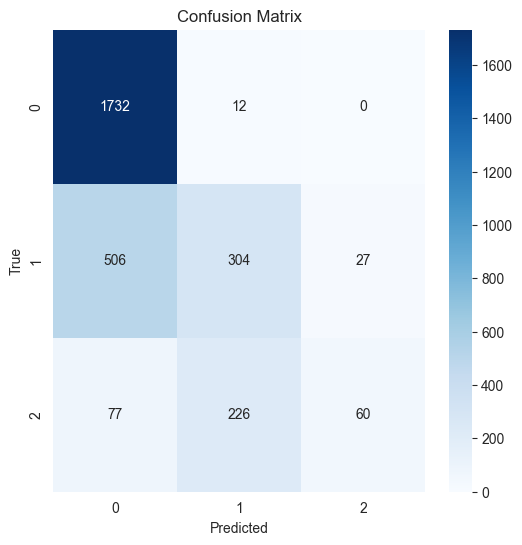

In [33]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

all_targets = []
all_predictions = []

trained_model.eval()
with torch.no_grad():
    for data, targets in test_dataloader:
        data, targets = data.to(device), targets.to(device)
        outputs = trained_model(data)
        preds = torch.argmax(outputs, dim=1)
        all_predictions.extend(preds.cpu().numpy())
        all_targets.extend(targets.cpu().numpy())

# Confusion Matrix
cm = confusion_matrix(all_targets, all_predictions)
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# 20% und 5 Epochen
![Confusion Matrix](Confusion_20pers_5Epoch.jpg)
# 100% und 1 Epoche
![Confusion Matrix](Confusion_100pers_1Ep.jpg)

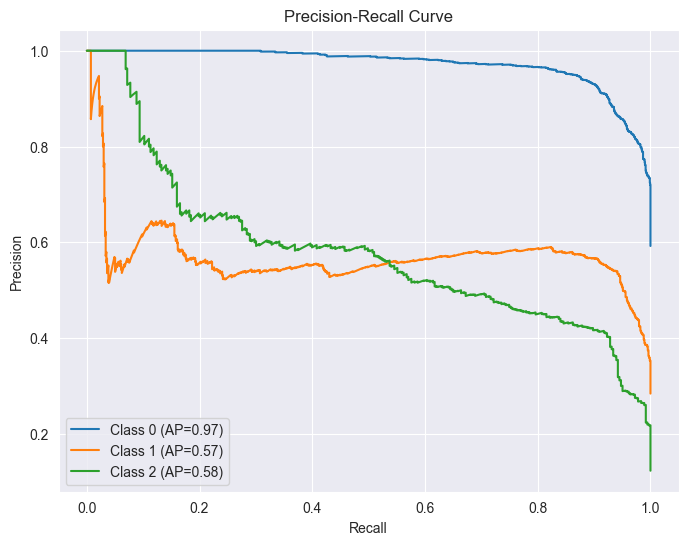

In [34]:
from sklearn.metrics import precision_recall_curve, average_precision_score

import numpy as np

# one-hot encode targets
num_classes = 3
targets_onehot = np.eye(num_classes)[all_targets]  # shape: (N, num_classes)
pred_probs = []

trained_model.eval()
with torch.no_grad():
    for data, _ in test_dataloader:
        data = data.to(device)
        outputs = trained_model(data)
        pred_prob = torch.softmax(outputs, dim=1).cpu().numpy()
        pred_probs.append(pred_prob)

pred_probs = np.vstack(pred_probs)  # shape: (N, num_classes)

# Plot PR Curve for each class
plt.figure(figsize=(8,6))
for i in range(num_classes):
    precision, recall, _ = precision_recall_curve(targets_onehot[:,i], pred_probs[:,i])
    ap = average_precision_score(targets_onehot[:,i], pred_probs[:,i])
    plt.plot(recall, precision, label=f"Class {i} (AP={ap:.2f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()


# 20% und 5 Epochen
![Confusion Matrix](PresisionRecall_20per_5epoch.jpg)
# 100% und 1 Epoche
![Confusion Matrix](PresisionRecall_100per_1epoch.jpg)